In [1]:
import wrangle as wr

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer



# Acquire and Summarize

In [3]:
df = wr.get_zillow_data()
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
...,...,...,...,...,...,...,...
2152859,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0
2152860,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2152861,0.0,0.0,NaN,208057.0,NaN,5783.88,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


In [5]:
wr.summarize_df(df)

This dataframe has 2152864 rows and 7 columns.
------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    float64
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  float64
 3   taxvaluedollarcnt             float64
 4   yearbuilt                     float64
 5   taxamount                     float64
 6   fips                          float64
dtypes: float64(7)
memory usage: 115.0 MB
None
------------------------

3.0     964298
4.0     634289
2.0     335473
5.0     150866
6.0      25166
1.0      23166
0.0      13188
7.0       4807
8.0       1107
9.0        291
10.0       121
11.0        34
13.0        16
12.0        12
NaN         11
14.0         7
15.0         6
18.0         3
16.0         2
25.0         1
Name: bedroomcnt, dtype: int64
2.00     943589
3.00    

In [6]:
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
dtype: int64

In [7]:
df.nunique()

bedroomcnt                          19
bathroomcnt                         38
calculatedfinishedsquarefeet     10580
taxvaluedollarcnt               592269
yearbuilt                          153
taxamount                       918838
fips                                 3
dtype: int64

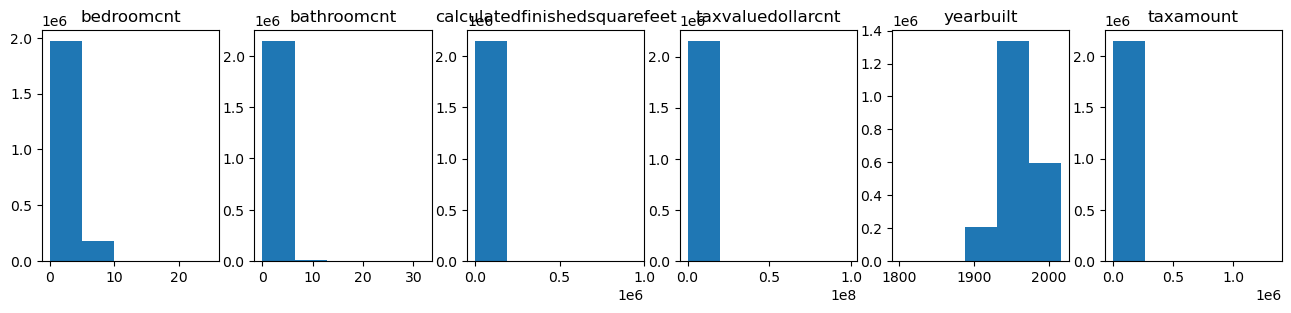

In [8]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

### Takeaways:
- Many null values need imputation or removal
- Some such as `calculatedfinishedsquarefeet` have so many missing vals, unique vals, and many outliers that it would be difficult to impute them all. Likely will drop them unless I come up with a more robust way to drop and impute

# Prepare

In [9]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [10]:
df.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'yearbuilt', 'taxamount', 'fips'],
      dtype='object')

In [11]:
df = remove_outliers(df, 1.5, ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'taxamount'])
df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037.0
...,...,...,...,...,...,...,...
2152853,3.0,2.0,1917.0,408680.0,1946.0,4341.32,6111.0
2152854,4.0,2.0,1987.0,259913.0,1955.0,3175.66,6059.0
2152856,3.0,2.5,1809.0,405547.0,2012.0,4181.10,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


In [12]:
df.isnull().sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet      0
taxvaluedollarcnt                 0
yearbuilt                       874
taxamount                         0
fips                              0
dtype: int64

In [14]:
df.fips = df.fips.astype(object)
df.year_built = df.yearbuilt.astype(object)

In [15]:
df = df.drop(columns=['taxamount'])

## Train, Validate, Test split

In [16]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [17]:
imp = SimpleImputer(strategy='most_frequent')  # build imputer

imp.fit(train[['yearbuilt']]) # fit to train

# transform the data
train[['yearbuilt']] = imp.transform(train[['yearbuilt']])
validate[['yearbuilt']] = imp.transform(validate[['yearbuilt']])
test[['yearbuilt']] = imp.transform(test[['yearbuilt']])

In [2]:
train, validate, test = wr.wrangle_zillow()

In [3]:
train

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips
10057,4.0,2.0,1561.0,248240.0,1973.0,6059.0
2004970,3.0,2.0,1770.0,88390.0,1960.0,6037.0
306031,2.0,1.0,1452.0,81169.0,1946.0,6037.0
1038595,3.0,1.0,1000.0,119174.0,1950.0,6037.0
270959,3.0,2.0,1974.0,432268.0,1988.0,6037.0
...,...,...,...,...,...,...
991122,3.0,1.0,1199.0,280857.0,1951.0,6111.0
1707759,4.0,2.0,1859.0,95008.0,1961.0,6037.0
1770246,3.0,3.0,2132.0,158470.0,1980.0,6037.0
1500741,2.0,1.0,780.0,477167.0,1955.0,6037.0


In [4]:
    cols = []
    for col, vals in train.iteritems():
        if train[f'{col}'].dtype != object:
            cols.append(col)

In [5]:
cols

['bedroomcnt',
 'bathroomcnt',
 'calculatedfinishedsquarefeet',
 'taxvaluedollarcnt',
 'yearbuilt']